In [1]:
import pickle
import os
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

In [8]:
class Transform:
    # Requirements:
        # import os
        # import pickle
        # import numpy as np
        # import pandas as pd
        # import matplotlib.pyplot as plt
    
    def __init__(self, keyword):
        self.keyword = keyword
        
    def aggFromPickles(self, inputPath):
        df = pd.DataFrame()
        for root, _, files in os.walk(inputPath):
            for file in sorted(files):
                if file.endswith(".pkl"):
                    year = file.split('-')[0]
                    month = file.split('-')[1]
                    with open(os.path.join(root, file), 'rb') as f:
                        df_temp = pickle.load(f)
                df_temp = pd.DataFrame(df_temp.iloc[:, 1:].mean(axis=0)).T
                df_temp['Year-month'] = year + '-' + month
                df = df.append(df_temp)
        
        df.columns = df.columns.str.replace('\"', '')
        df['Year-month'] = pd.to_datetime(df['Year-month']).sort_values()
        
        # Reordering columns to have 'Year-month' as the first column
        df = df.reset_index(drop=True)
        col_order = ['Year-month'] + (df.columns.tolist()[:-1])
        df = df[col_order]
        self.df = df
    
    def lineplot(self):
        plt.figure(figsize=(9,7))
        for i in range(1, len(self.df.columns)):
            plt.plot(self.df.iloc[:,0], self.df.iloc[:, i])
        # plt.xticks(np.arange(0, len(self.df), 12), 
                   # list(map(str, self.df['Year-month'].dt.year.unique())), 
                   # rotation=60)
        plt.ylim(bottom=0)
        plt.xlabel('Year')
        plt.ylabel('Global mean')
        plt.title('Keyword: \'{}\''.format(self.keyword.capitalize()))
        plt.legend()
        plt.show()
    
    def toPickle(self, outputPath):
        fileName = 'transform-{}'.format(self.keyword)
        pathName = '{}/{}.pkl'.format(outputPath, fileName)
        with open(pathName, 'wb') as f:
            pickle.dump(self.df, f)

class Transform_keyword(Transform):
# Subclass of class Transform
    def __init__(self, keyword):
        super().__init__(keyword)

    def path(self):
        return '../data/raw/{}'.format(self.keyword)

    def aggFromPickles(self):
        super().aggFromPickles(self.path())

No handles with labels found to put in legend.


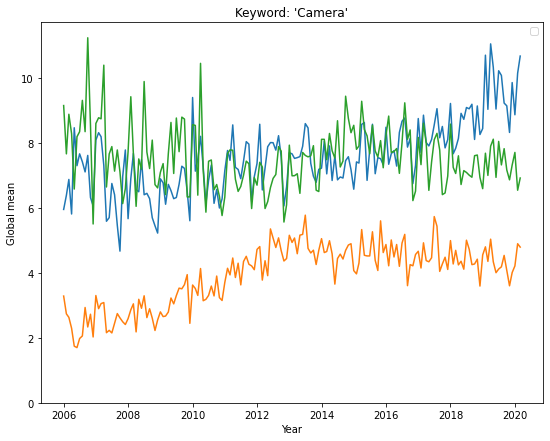

No handles with labels found to put in legend.


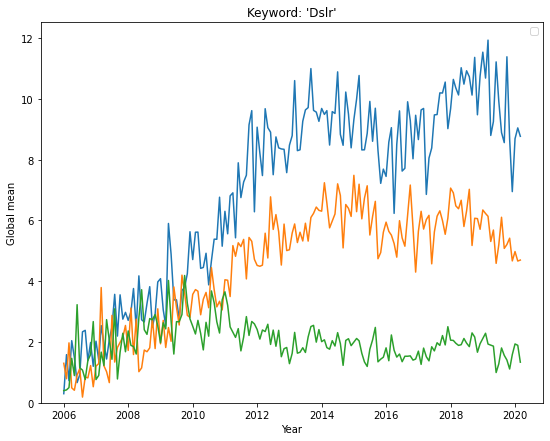

No handles with labels found to put in legend.


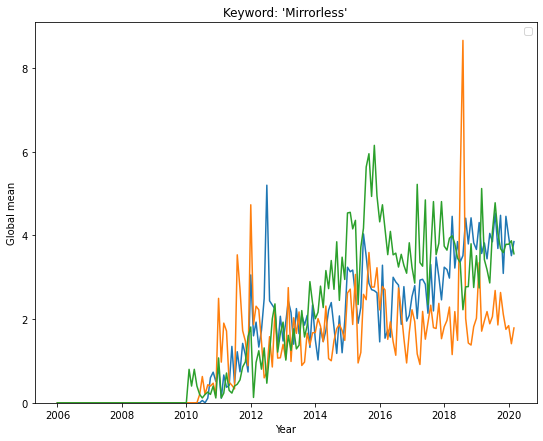

In [12]:
def main():
    t_cam = Transform_keyword('camera')
    t_cam.aggFromPickles()
    t_cam.lineplot()

    t_dslr = Transform_keyword('dslr')
    t_dslr.aggFromPickles()
    t_dslr.lineplot()

    t_ml = Transform_keyword('mirrorless')
    t_ml.aggFromPickles()
    t_ml.lineplot()

if __name__ == '__main__':
    main()

No handles with labels found to put in legend.


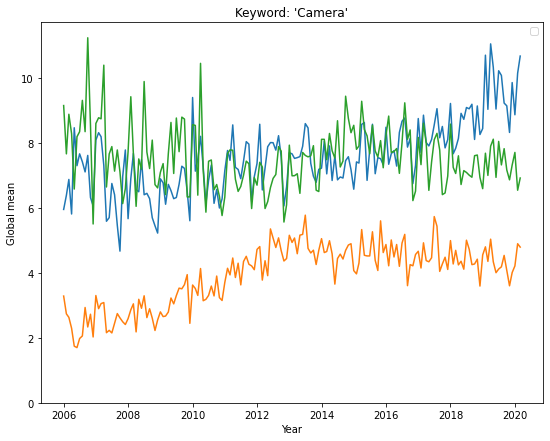

In [13]:
t = Transform('camera')
# print(t.keyword)
t.aggFromPickles('../data/raw/camera')
# print(t.df)
# print(t.df.sort_values(by='Year-month').head(10))
t.lineplot()

In [ ]:
t.toPickle('pickleTest')

In [ ]:
t1 = Transform('mirrorless')
t1.aggFromPickles('../data/raw/mirrorless')
print(t.df)
t1.lineplot()

In [ ]:
t2 = Transform('dslr')
t2.aggFromPickles('../data/raw/dslr')
print(t2.df)
t2.lineplot()

In [ ]:
with open('pickleTest/transform-camera.pkl', 'rb') as f:
    myobject = pickle.load(f)

In [ ]:
myobject

In [ ]:
df = pd.DataFrame()
for root, dirs, files in os.walk("../data/raw/camera"):
    for file in files:
        if file.endswith(".pkl"):
            year = file.split('-')[0]
            month = file.split('-')[1]
            with open(os.path.join(root, file), 'rb') as f:
                df_temp = pickle.load(f)
        df_temp = pd.DataFrame(df_temp.iloc[:, 1:].mean()).T
        df_temp['Year-month'] = year + '-' + month
        df = df.append(df_temp)

df.columns = df.columns.str.replace('"', '')
df = df.reset_index(drop=True)

In [ ]:
df

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(df.iloc[:, 0])
plt.xticks(np.arange(0, 171, 12), np.arange(2006, 2021), rotation=60)
plt.show()

In [ ]:
with open('data/agg-camera.pkl', 'wb') as f:
            pickle.dump(self.trend, f)

In [ ]:
#a = pd.DataFrame()
a = a.append(edit)
a

In [ ]:
os.getcwd()

In [ ]:
edit = pd.DataFrame(testObject.iloc[:, 1:].mean()).T
edit.columns = edit.columns.str.replace('"', '')
edit['Year-month'] = 'test'
#edit.columns = ['Year-month', '"Canon" "camera"', '"Nikon" "camera"', '"Sony" "camera"']
#edit_copy = edit.copy()
#testObject.append(edit_copy)
#testObject
edit

In [ ]:
test2 = pd.DataFrame({'Canon camera': [1,2], 
                      'Nikon camera': [2,3], 
                      'Sony camera': [3,4], 
                      'Year-month': ['2019-04', '2020-03']}
                    )
order = ['Year-month'] + (test2.columns.tolist()[:-1])
test2 = test2[order]
test2['Year-month'] = pd.to_datetime(test2['Year-month'])
#test2['Month'] = 
test2['Year-month'].dt.year.unique()
print(len(test2))

In [ ]:
edit = edit.append(test2)
edit

In [ ]:
'"Nikon" "camera"'.replace('"', '')

In [ ]:
testObject.loc[testObject['"Canon" "camera"']==100]

In [ ]:
testObject